## Evaluation file for Lemur identification

In this file, you can apply the Lemur identification model to a list of images and compare to the ground truth.

### Imports

In [137]:
import sys
if '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages' not in sys.path:
    sys.path.insert(0, '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src/lib')

import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import _init_paths
from models.model import create_model, load_model
from models.decode import mot_decode, _topk, map2orig
from tracking_utils.utils import *
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
import datasets.jde as datasets

In [138]:
!pwd

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks


### Load model and data

In [155]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0)

#model = load_model(model, '../models/hrnet/hrnet32_lemurids.pth')
model = load_model(model, '../exp/mot/lemur_ids/model_last.pth')
model = model.to(torch.device('cuda'))
model.eval()
print("ok")

=> loading pretrained model ../models/hrnetv2_w32_imagenet_pretrained.pth
loaded ../exp/mot/lemur_ids/model_last.pth, epoch 28
ok


### Get number of individuals in labels

In [156]:
path = "/usr/users/vogg/Labelling/Lemurs/Individual_imgs/images/"
image_format = ['.jpg', '.jpeg', '.png', '.tif']
files = sorted(glob.glob('%s/*.*' % path))
files = list(filter(lambda x: os.path.splitext(x)[1].lower() in image_format, files))
print(files[0])

labels = [pd.read_csv(path + "../labels_with_ids/" + files[i].split("images/")[1].split(".")[0] + ".txt", 
                      sep = " ", header = None) for i, selected_file in enumerate(files)]

final_df = pd.concat(labels, ignore_index=True)

final_df.groupby(6).count()[0]

/usr/users/vogg/Labelling/Lemurs/Individual_imgs/images/GX010011_small_4396.jpg


6
0      5
1     46
2     41
3     61
4     45
5     85
6     34
7    879
Name: 0, dtype: int64

In [157]:
path = "/usr/users/vogg/Labelling/Lemurs/Individual_imgs/eval/"
image_format = ['.jpg', '.jpeg', '.png', '.tif']
files = sorted(glob.glob('%s/*.*' % path))
files = list(filter(lambda x: os.path.splitext(x)[1].lower() in image_format, files))

### Get model predictions for one image

In [158]:
selected_file = 15


img0 = cv2.imread(files[selected_file])  # BGR
true_id = files[selected_file].split("eval/")[1].split(".")[0]
out = pd.read_csv(path + "../labels_with_ids/" + true_id + ".txt", 
                  sep = " ", header = None)
labels = out[6]
labels = list(set(labels[labels!=7]))
if len(labels) == 0:
    labels = [7]
labels

[4]

In [159]:
img_box, _, _, _ = datasets.letterbox(img0, height=608, width=1088)

# Normalize RGB
img = img_box[:, :, ::-1].transpose(2, 0, 1)
img = np.ascontiguousarray(img, dtype=np.float32)
img /= 255.0

im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

width = img0.shape[1]
height = img0.shape[0]
inp_height = im_blob.shape[2]
inp_width = im_blob.shape[3]
h_out = inp_height // 4
w_out = inp_width // 4


with torch.no_grad():
    output = model(im_blob)[-1]
    hm = output['hm'].sigmoid_()
    wh = output['wh']
    id_feature = output['id']
    id_feature = F.normalize(id_feature, dim=1)

    reg = output['reg']

    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=2,
                                           cat_spec_wh=False,
                                           K=50)

mnk_inds = inds[:, cls_inds_mask[0]]


output['pose'] = model.gc_lin(output['gc'], mnk_inds)
# 
pose_score = output['pose']

# translate and scale
dets = map2orig(dets, h_out, w_out, height, width, 2)

In [160]:
# only keep predictions if the maximum prediction is larger than a threshold
# i.e. the model has to be somewhat certain about what individual this is
print(np.round(pose_score.cpu().numpy()[0],2))
larger = torch.gt(torch.max(pose_score, 1)[0], 0.2).squeeze().cpu().numpy()
pose = torch.max(pose_score, 1)[1].squeeze().cpu().numpy()
pose = [pose[i] if larger[i] else None for i in range(len(pose))]


indivs = ['Amb','Cam','Cha','Che','Flo','Gen','Geo','Har','Her',
          'Isa','Kai','Lat','Mya','Pal','Rab','Red','Sap','Taj']
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']

print(indivs[pose[0]])
print([indivs[i] for i in labels])

[          0           0           0           0        0.02           0           0        0.98]
Uns
['Her']


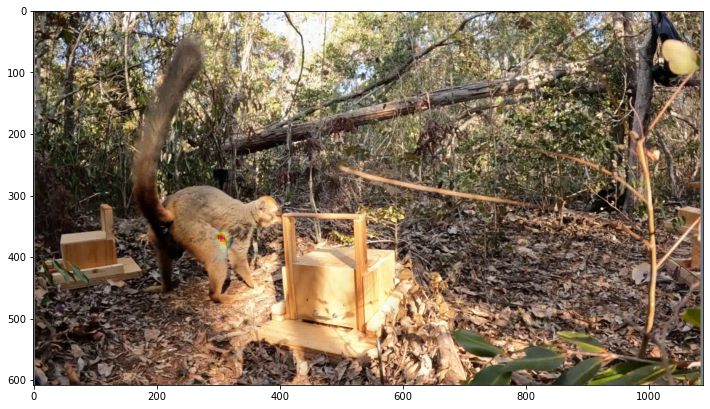

In [161]:
fig, ax = plt.subplots(figsize=(12, 7))

hm_local = hm.cpu()
#hm2 = _nms(hm_local)

ax.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB), alpha = 1)
scores, inds, clses, ys, xs, _ = _topk(hm_local)
hm_local = F.interpolate(hm_local, scale_factor = 4)
hm_local = torch.squeeze(hm_local)


ax.imshow(hm_local[0,:,:], alpha = hm_local[0,:,:], cmap='jet')
plt.show()

### Visualize prediction heatmaps

Read out the pose head at each pixel location of the feature volume to see in which areas the model predicts certain individuals.

In [146]:
#whole image
total_pixels = (inp_width // 4) * (inp_height // 4) # gives 41344
inds = torch.Tensor([list(range(total_pixels))]).to(torch.int64).to(torch.device('cuda'))

output['pose'] = model.gc_lin(output['gc'], inds)
output['pose'].shape

torch.Size([41344, 8])

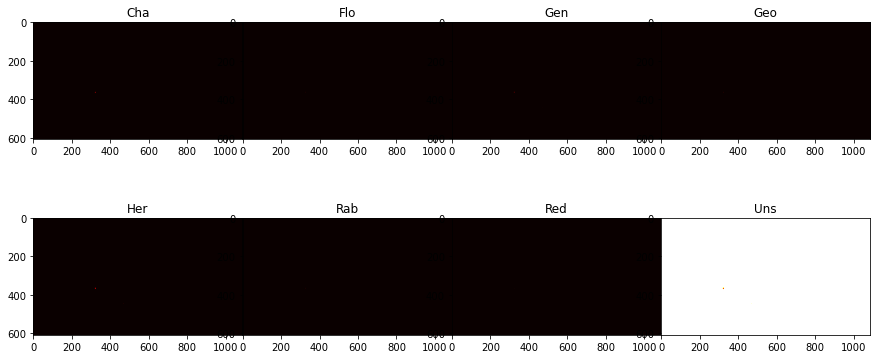

In [147]:
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']


fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(indivs)):

    activation_mat = output['pose'].cpu().numpy()[:,i].reshape((inp_height//4, inp_width//4))
    act_mat = np.kron(activation_mat, np.ones((4,4)))
    norm = TwoSlopeNorm(vcenter=0.5, vmin=0, vmax=1)
    axs[i].imshow(act_mat, cmap='hot', interpolation='nearest', norm = norm)
    #axs[i].imshow(act_mat, cmap='hot', interpolation='nearest')
    axs[i].set_title(indivs[i])


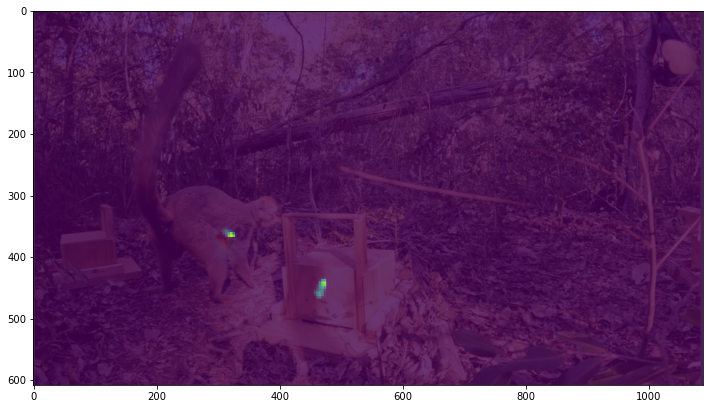

In [133]:
indiv = 5

fig, ax = plt.subplots(figsize=(12, 7))

hm_local = hm.cpu()

ax.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB), alpha = 1)
scores, inds, clses, ys, xs, _ = _topk(hm_local)
hm_local = F.interpolate(hm_local, scale_factor = 4)
hm_local = torch.squeeze(hm_local)

activation_mat = output['pose'].cpu().numpy()[:,indiv].reshape((inp_height//4, inp_width//4))
act_mat = np.kron(activation_mat, np.ones((4,4)))
ax.imshow(hm_local[0,:,:], alpha = hm_local[0,:,:], cmap='jet')
ax.imshow(act_mat, alpha = 0.8)
plt.show()

### Get model predictions for all validation images

In [134]:
gt = []
pred = []

for selected_file in range(len(files)):
    try:
        #load image and labels
        img0 = cv2.imread(files[selected_file])  # BGR
        true_id = files[selected_file].split("eval/")[1].split(".")[0] 
        out = pd.read_csv(path + "../labels_with_ids/" + true_id + ".txt", 
                  sep = " ", header = None)
        labels = out[6]
        labels = list(set(labels[labels!=7]))
        if len(labels) == 0:
            labels = [7]


        img_box, _, _, _ = datasets.letterbox(img0, height=608, width=1088)

        # Normalize RGB
        img = img_box[:, :, ::-1].transpose(2, 0, 1)
        img = np.ascontiguousarray(img, dtype=np.float32)
        img /= 255.0

        im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

        width = img0.shape[1]
        height = img0.shape[0]
        inp_height = im_blob.shape[2]
        inp_width = im_blob.shape[3]

        with torch.no_grad():
            output = model(im_blob)[-1]
            hm = output['hm'].sigmoid_()
            wh = output['wh']
            reg = output['reg']

            dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                                   wh=wh,
                                                   reg=reg,
                                                   num_classes=2,
                                                   cat_spec_wh=False,
                                                   K=50)


        mnk_inds = inds[:, cls_inds_mask[0]]

        output['pose'] = model.gc_lin(output['gc'], mnk_inds)
        # 
        pose_score = output['pose']

        # translate and scale
        dets = map2orig(dets, inp_height, inp_width, height, width, 2)
        larger = torch.gt(torch.max(pose_score[:-1], 1)[0], 0.2).squeeze().cpu().numpy()
        pose = torch.max(pose_score, 1)[1].squeeze().cpu().numpy()
        #pose = torch.topk(pose_score, 2, 1)[1].squeeze().cpu().numpy()
        #pose = [pose[i][0] if pose[i][0]!=7 else pose[i][1] for i in range(len(pose))]
        #pose = [pose[i] if larger[i] else None for i in range(len(pose))]


        #indivs = ['Amb','Cam','Cha','Che','Flo','Gen','Geo','Har','Her',
        #          'Isa','Kai','Lat','Mya','Pal','Rab','Red','Sap','Taj']
        indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']
        if pose[0] is None:
            pred.append("None")
        else:
            pred.append(indivs[pose[0]])

        gt.append([indivs[i] for i in labels][0])
        
    except:
        print(selected_file, " not found")

In [135]:
#show list of all predictions and ground truths
for elem1, elem2 in zip(gt, pred):
    print(elem1, elem2)

Red Uns
Red Flo
Red Flo
Rab Uns
Rab Uns
Rab Flo
Rab Flo
Rab Flo
Rab Uns
Rab Uns
Rab Red
Gen Flo
Gen Uns
Her Uns
Flo Rab
Her Uns
Gen Rab
Gen Flo
Gen Uns
Flo Uns
Her Uns
Red Uns
Flo Uns
Her Rab
Flo Uns
Red Flo
Red Red
Geo Uns
Her Uns
Rab Flo
Her Uns
Her Her
Gen Uns
Geo Flo


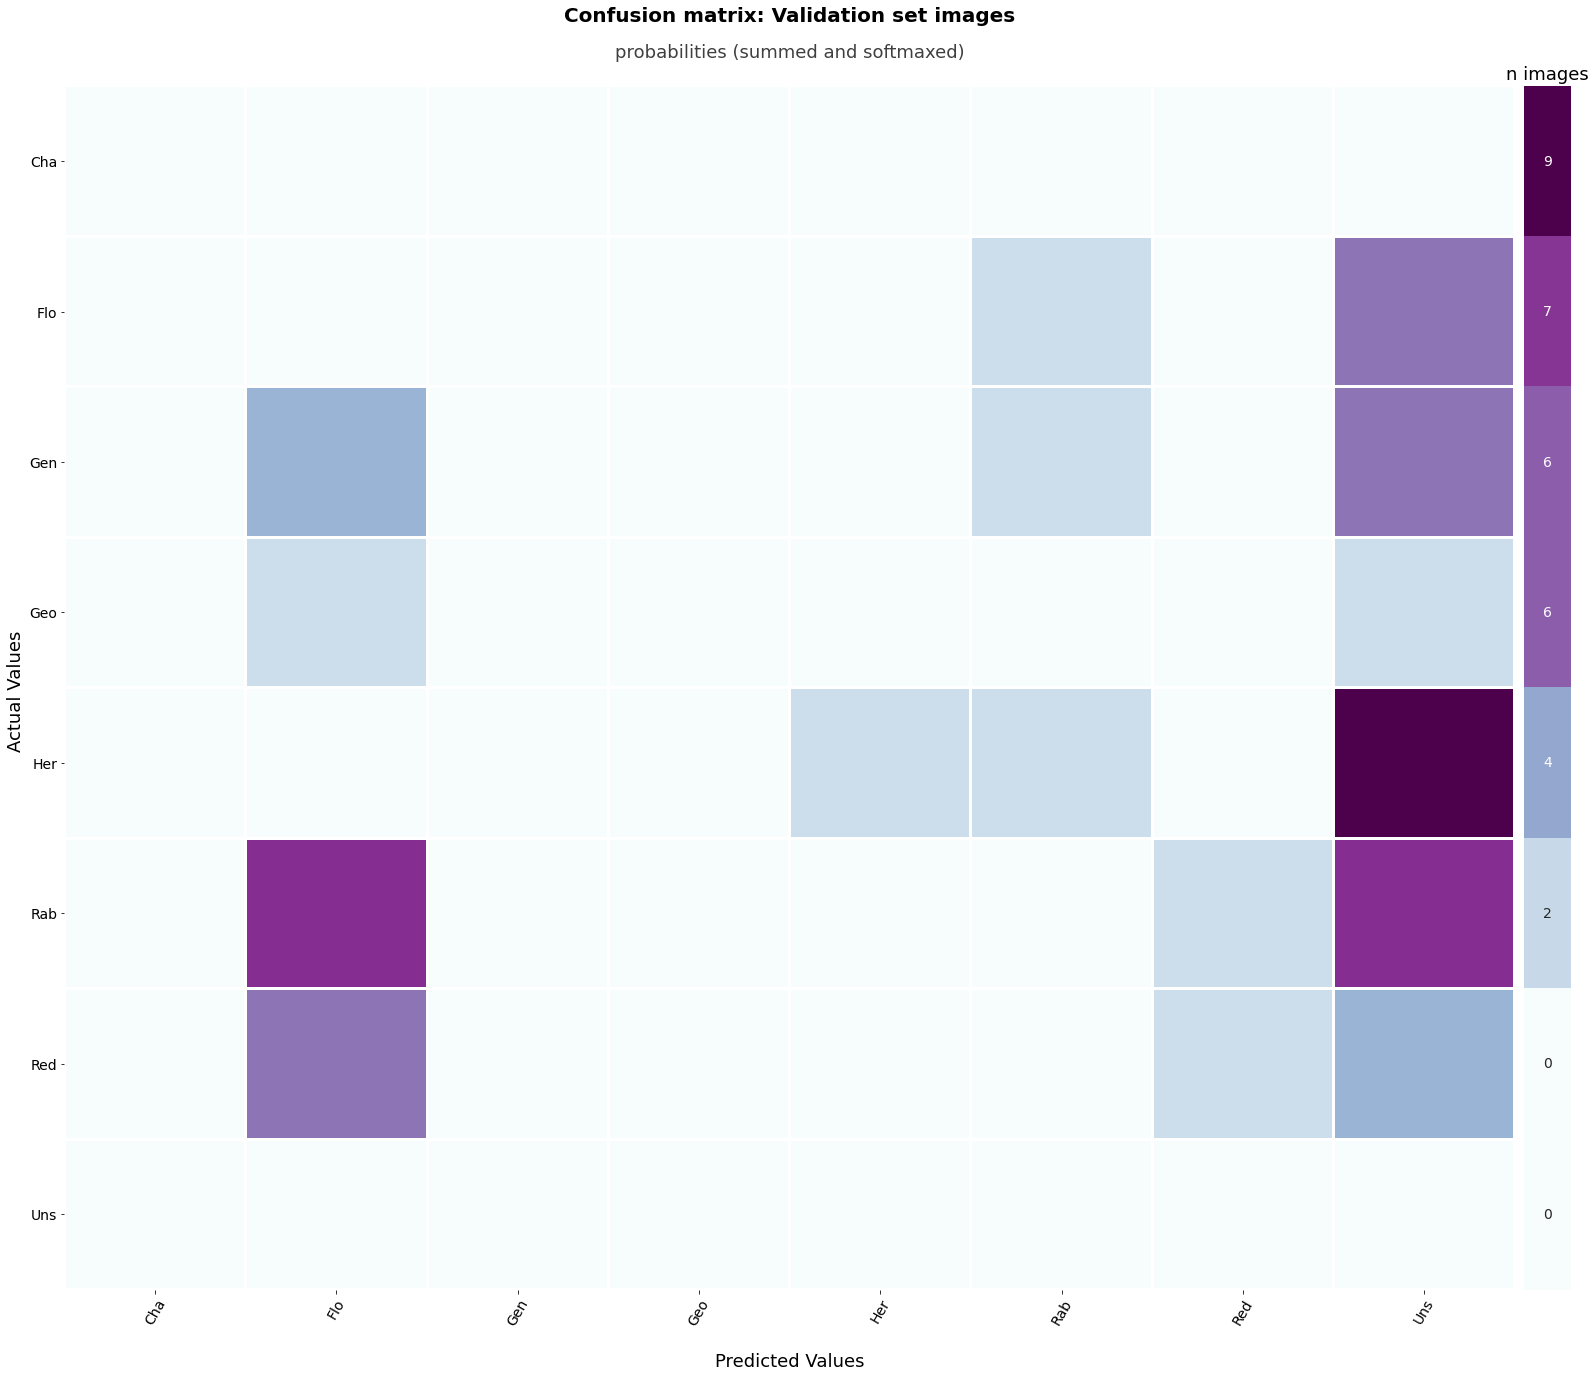

In [136]:



cm_full = confusion_matrix(gt, pred, labels = sorted(indivs)) #for row sums

n_training_photos = cm_full.sum(axis = 1)
n_sorted = sorted(n_training_photos, reverse = True)
ids_sorted = sorted(indivs, reverse = False)
cm = cm_full #df.reindex(index = ids_sorted, columns = ids_sorted)

plt.figure(figsize=(27, 23))
ax1 = plt.subplot2grid((27,27), (0,0), colspan=26, rowspan=26)
ax2 = plt.subplot2grid((27,27), (0,26), colspan=1, rowspan=26)

conf_mat = sn.heatmap(cm, cmap='BuPu', linewidths = 2, annot = False, cbar = False, ax = ax1, fmt = '.1g')

sn.heatmap(pd.DataFrame(n_sorted), ax=ax2,  annot=True, cmap="BuPu", 
           cbar=False, xticklabels=False, yticklabels=False, fmt='g', annot_kws={"size": 14});

title_text = "Confusion matrix: Validation set images"

subtitle_text = "probabilities (summed and softmaxed)"
    
conf_mat.text(x=0.5, y=1.05, s=title_text, fontsize=20, weight='bold', ha='center', va='bottom', transform=conf_mat.transAxes)
conf_mat.text(x=0.5, y=1.02, s=subtitle_text, fontsize=18, alpha=0.75, ha='center', va='bottom', transform=conf_mat.transAxes)

conf_mat.set_xticklabels(ids_sorted, rotation=60, fontsize = 14)
conf_mat.set_yticklabels(ids_sorted, rotation=0, fontsize = 14)
conf_mat.set_xlabel('\nPredicted Values', fontsize = 18)
conf_mat.set_ylabel('Actual Values ', fontsize = 18)
ax2.set_title('n images', fontsize = 18)

plt.show()